# Project 2 (Bag-of-words classifier)

This project is the implementation of an image classifier based on the bag-of-words approach. 

The provided dataset, in `images` folder, contains 15 categories (office, kitchen, living room, bedroom, store, industrial, tall building, inside city, street, highway, coast, open country, mountain, forest, suburb) and is already divided in training set and test set.

#### Import the necessary libraries

In [1]:
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels, chi2_kernel
from sklearn.multiclass import OutputCodeClassifier

from utility.visualVocabulary import VisualVocabulary
from utility.histograms import *
from utility.images import load_images
from utility.sift import extract_sift_descriptors
from utility.function_utils import *


#### Define the size of the visual vocabulary and the number of SIFT descriptors choosen

In [2]:
CLUSTER_NUMBER = 200
N_SIFT_FEATURES = 800
N_SUBSET_SIFT = 200000

#### Load train and test images from folders

In [3]:
train_images = load_images('images/train')
test_images = load_images("images/test")

#### Here we create the vocabulary

You don't need to execute this cell because the vocabulary was already constructed.

It is saved as picke file in the folder `pickled`.

We decide to keep these line code to show you how we computed the different values that we will use soon.

WARNING: unfortunately, due to the computational heavy of the UNC, we implement a code which use the GPU to calculate these values. So to run the code below you must have a GPU with CUDA's drivers.

In [4]:
vv = VisualVocabulary(CLUSTER_NUMBER, N_SIFT_FEATURES, N_SUBSET_SIFT)
vocabulary, quantized_train_images, UNC_train_images, pyramid_train_histogram = vv.create_vocabulary(train_images)
vv_file = open('pickled/vocabulary.pkl', 'wb')
pickle.dump(vv, vv_file)
vv_file = open('pickled/quantized.pkl', 'wb')
pickle.dump(quantized_train_images, vv_file)
vv_file = open('pickled/UNC.pkl', 'wb')
pickle.dump(UNC_train_images, vv_file)
vv_file = open('pickled/pyramid.pkl', 'wb')
pickle.dump(pyramid_train_histogram, vv_file)

Run this cell to load the vocabulary from the pickle file

In [4]:
vv_file = open('pickled/vocabulary.pkl', 'rb')
vv = pickle.load(vv_file)
vv_file = open('pickled/quantized.pkl', 'rb')
quantized_train_images = pickle.load(vv_file)
vv_file = open('pickled/UNC.pkl', 'rb')
UNC_train_images = pickle.load(vv_file)
vv_file = open('pickled/pyramid.pkl', 'rb')
pyramid_train_histogram = pickle.load(vv_file)
vv_file.close()

#### Obtain train histograms

In [5]:
train_histograms = create_histograms(quantized_train_images, vv.vocabulary)
UNC_train_histogram = create_UNC_histogram(UNC_train_images, vv.vocabulary)

We decided to plot one histogram for every class.

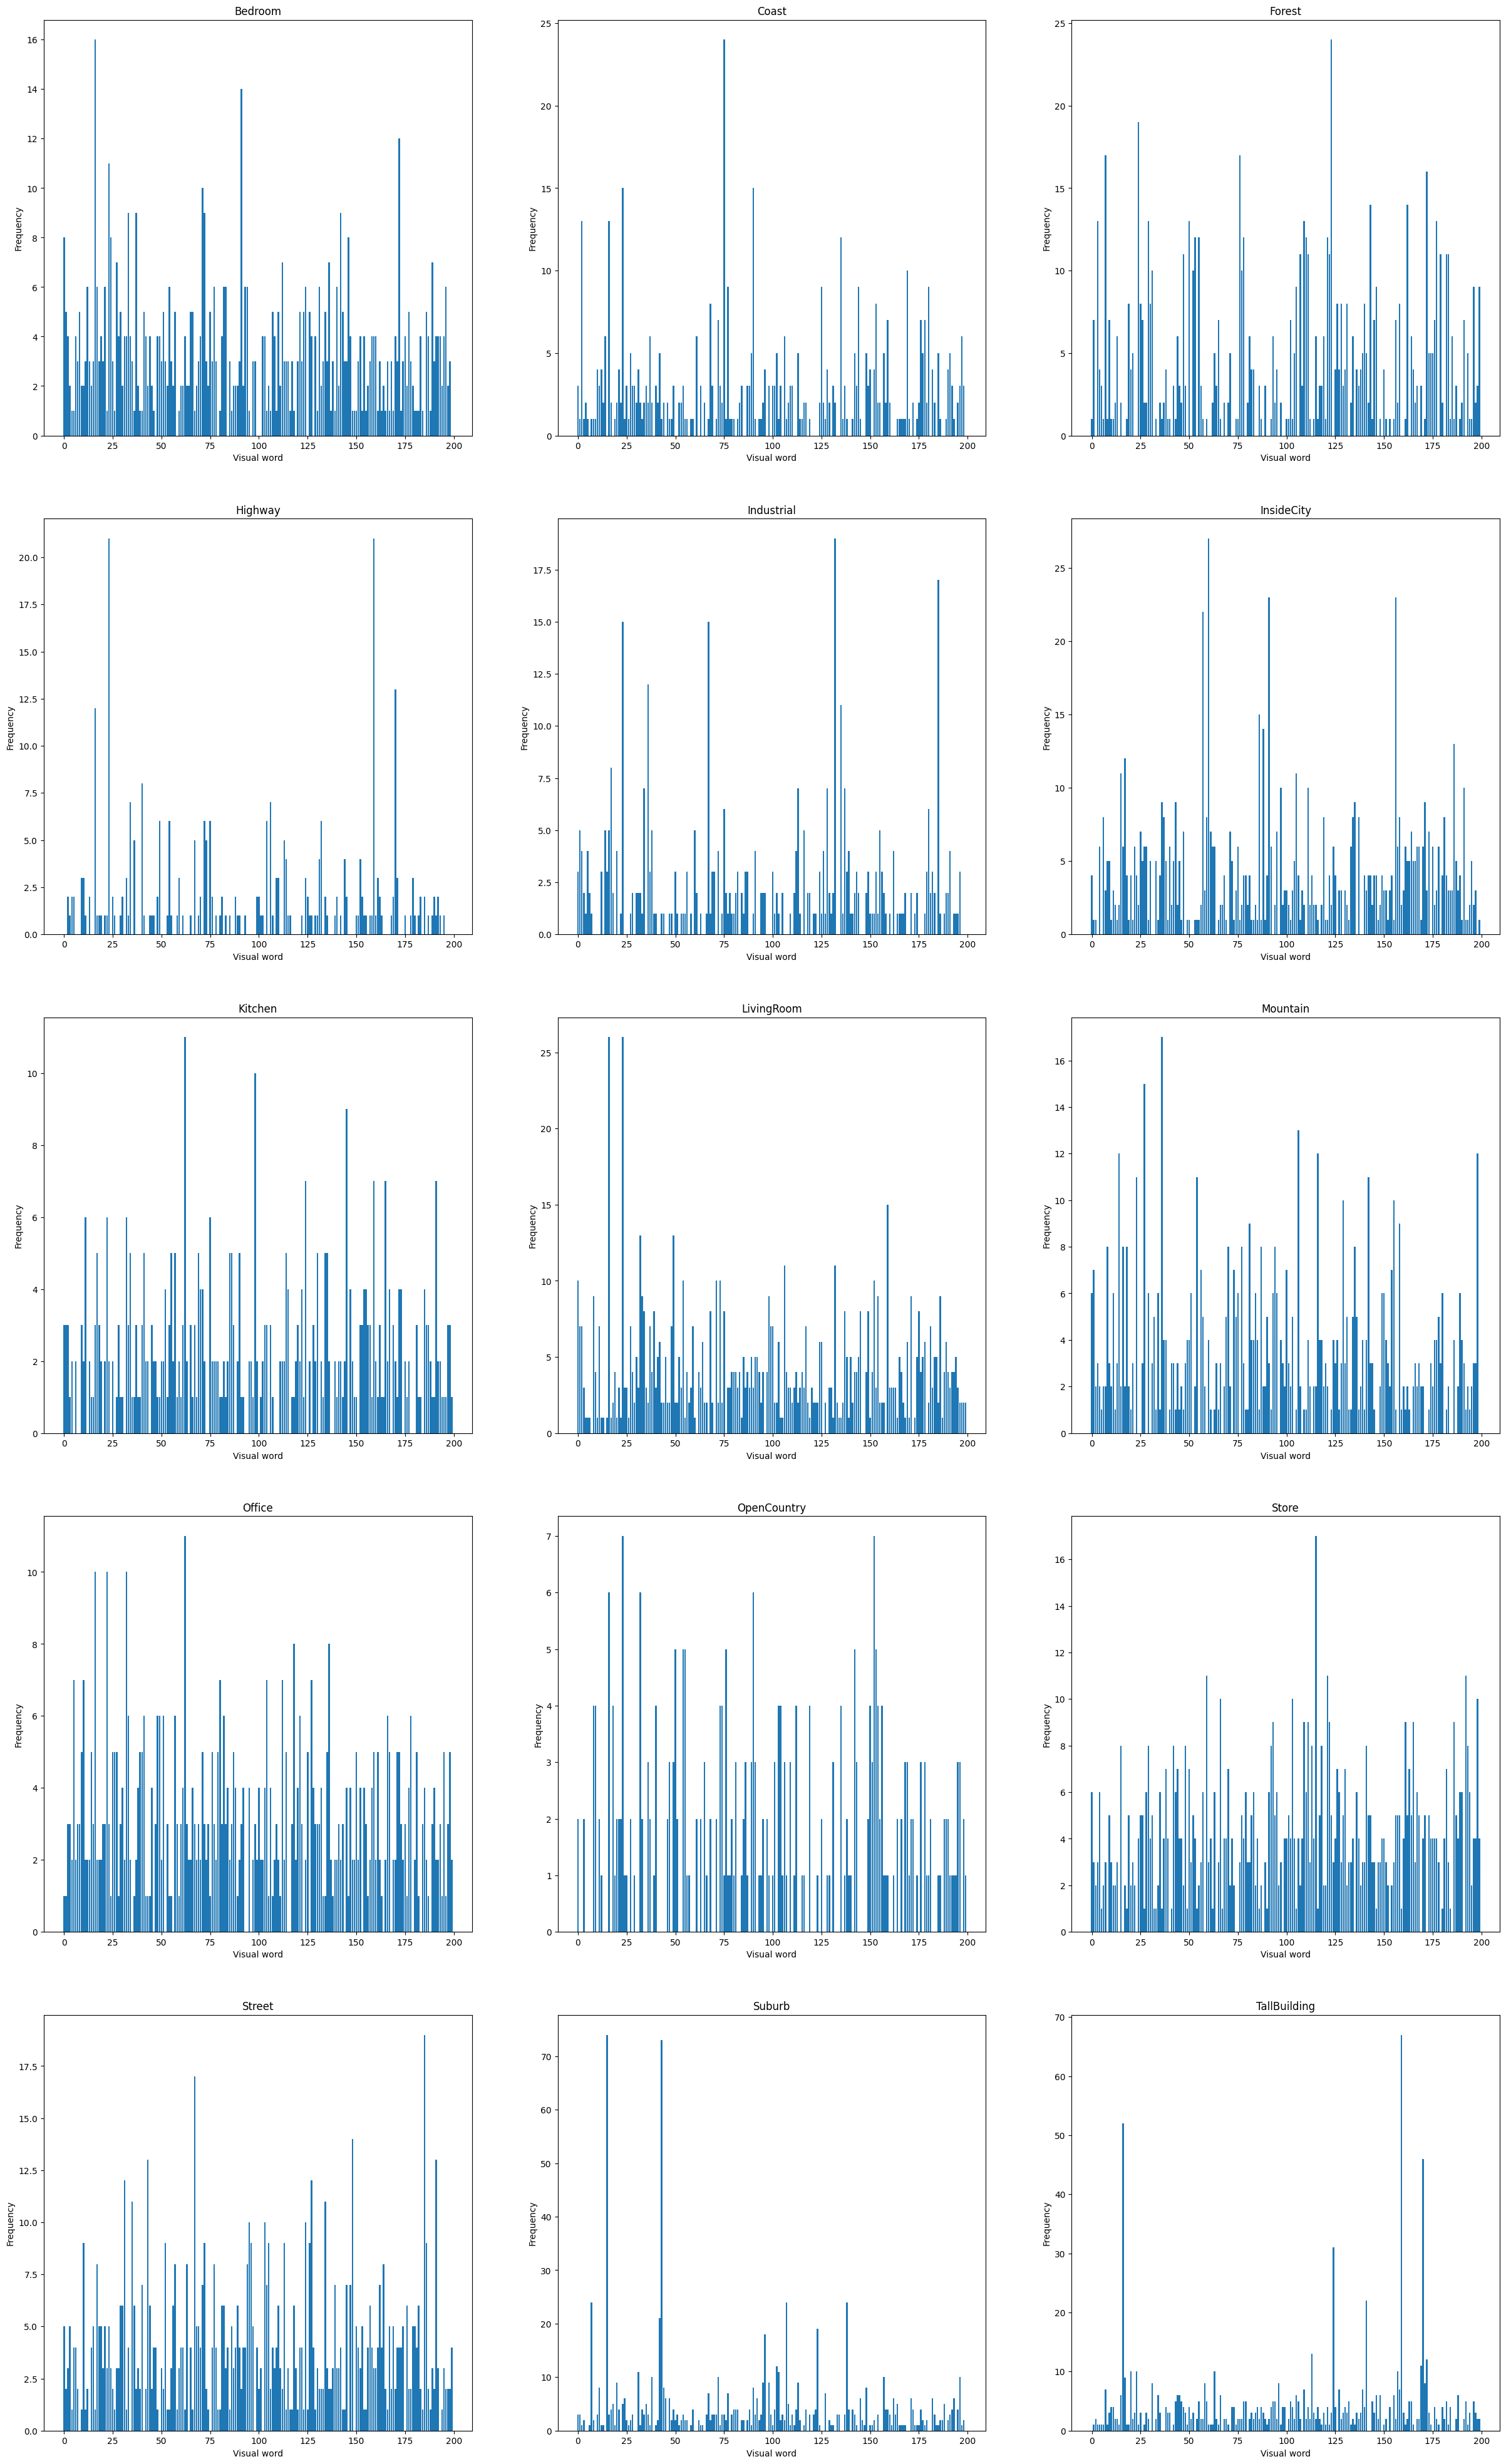

In [6]:
fig, ax = plt.subplots(5, 3, figsize=(30, 50))
indices = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
i = [train_histograms[idx]['histogram'] for idx in indices]
l = [train_histograms[idx]['label'] for idx in indices]
ax = np.ravel(ax)
for index, hist in enumerate(i):
    ax[index].bar(list(range(CLUSTER_NUMBER)), hist)
    ax[index].set_xlabel('Visual word')
    ax[index].set_ylabel('Frequency')
    ax[index].set_title(l[index])
plt.show()

#### Histograms normalization through TF-IDF

In [7]:
idf_train = calculate_idf(train_histograms, len(vv.vocabulary))
normalized_train_histograms = tfidf_histograms(train_histograms, idf_train)

And plot the resulting ones.

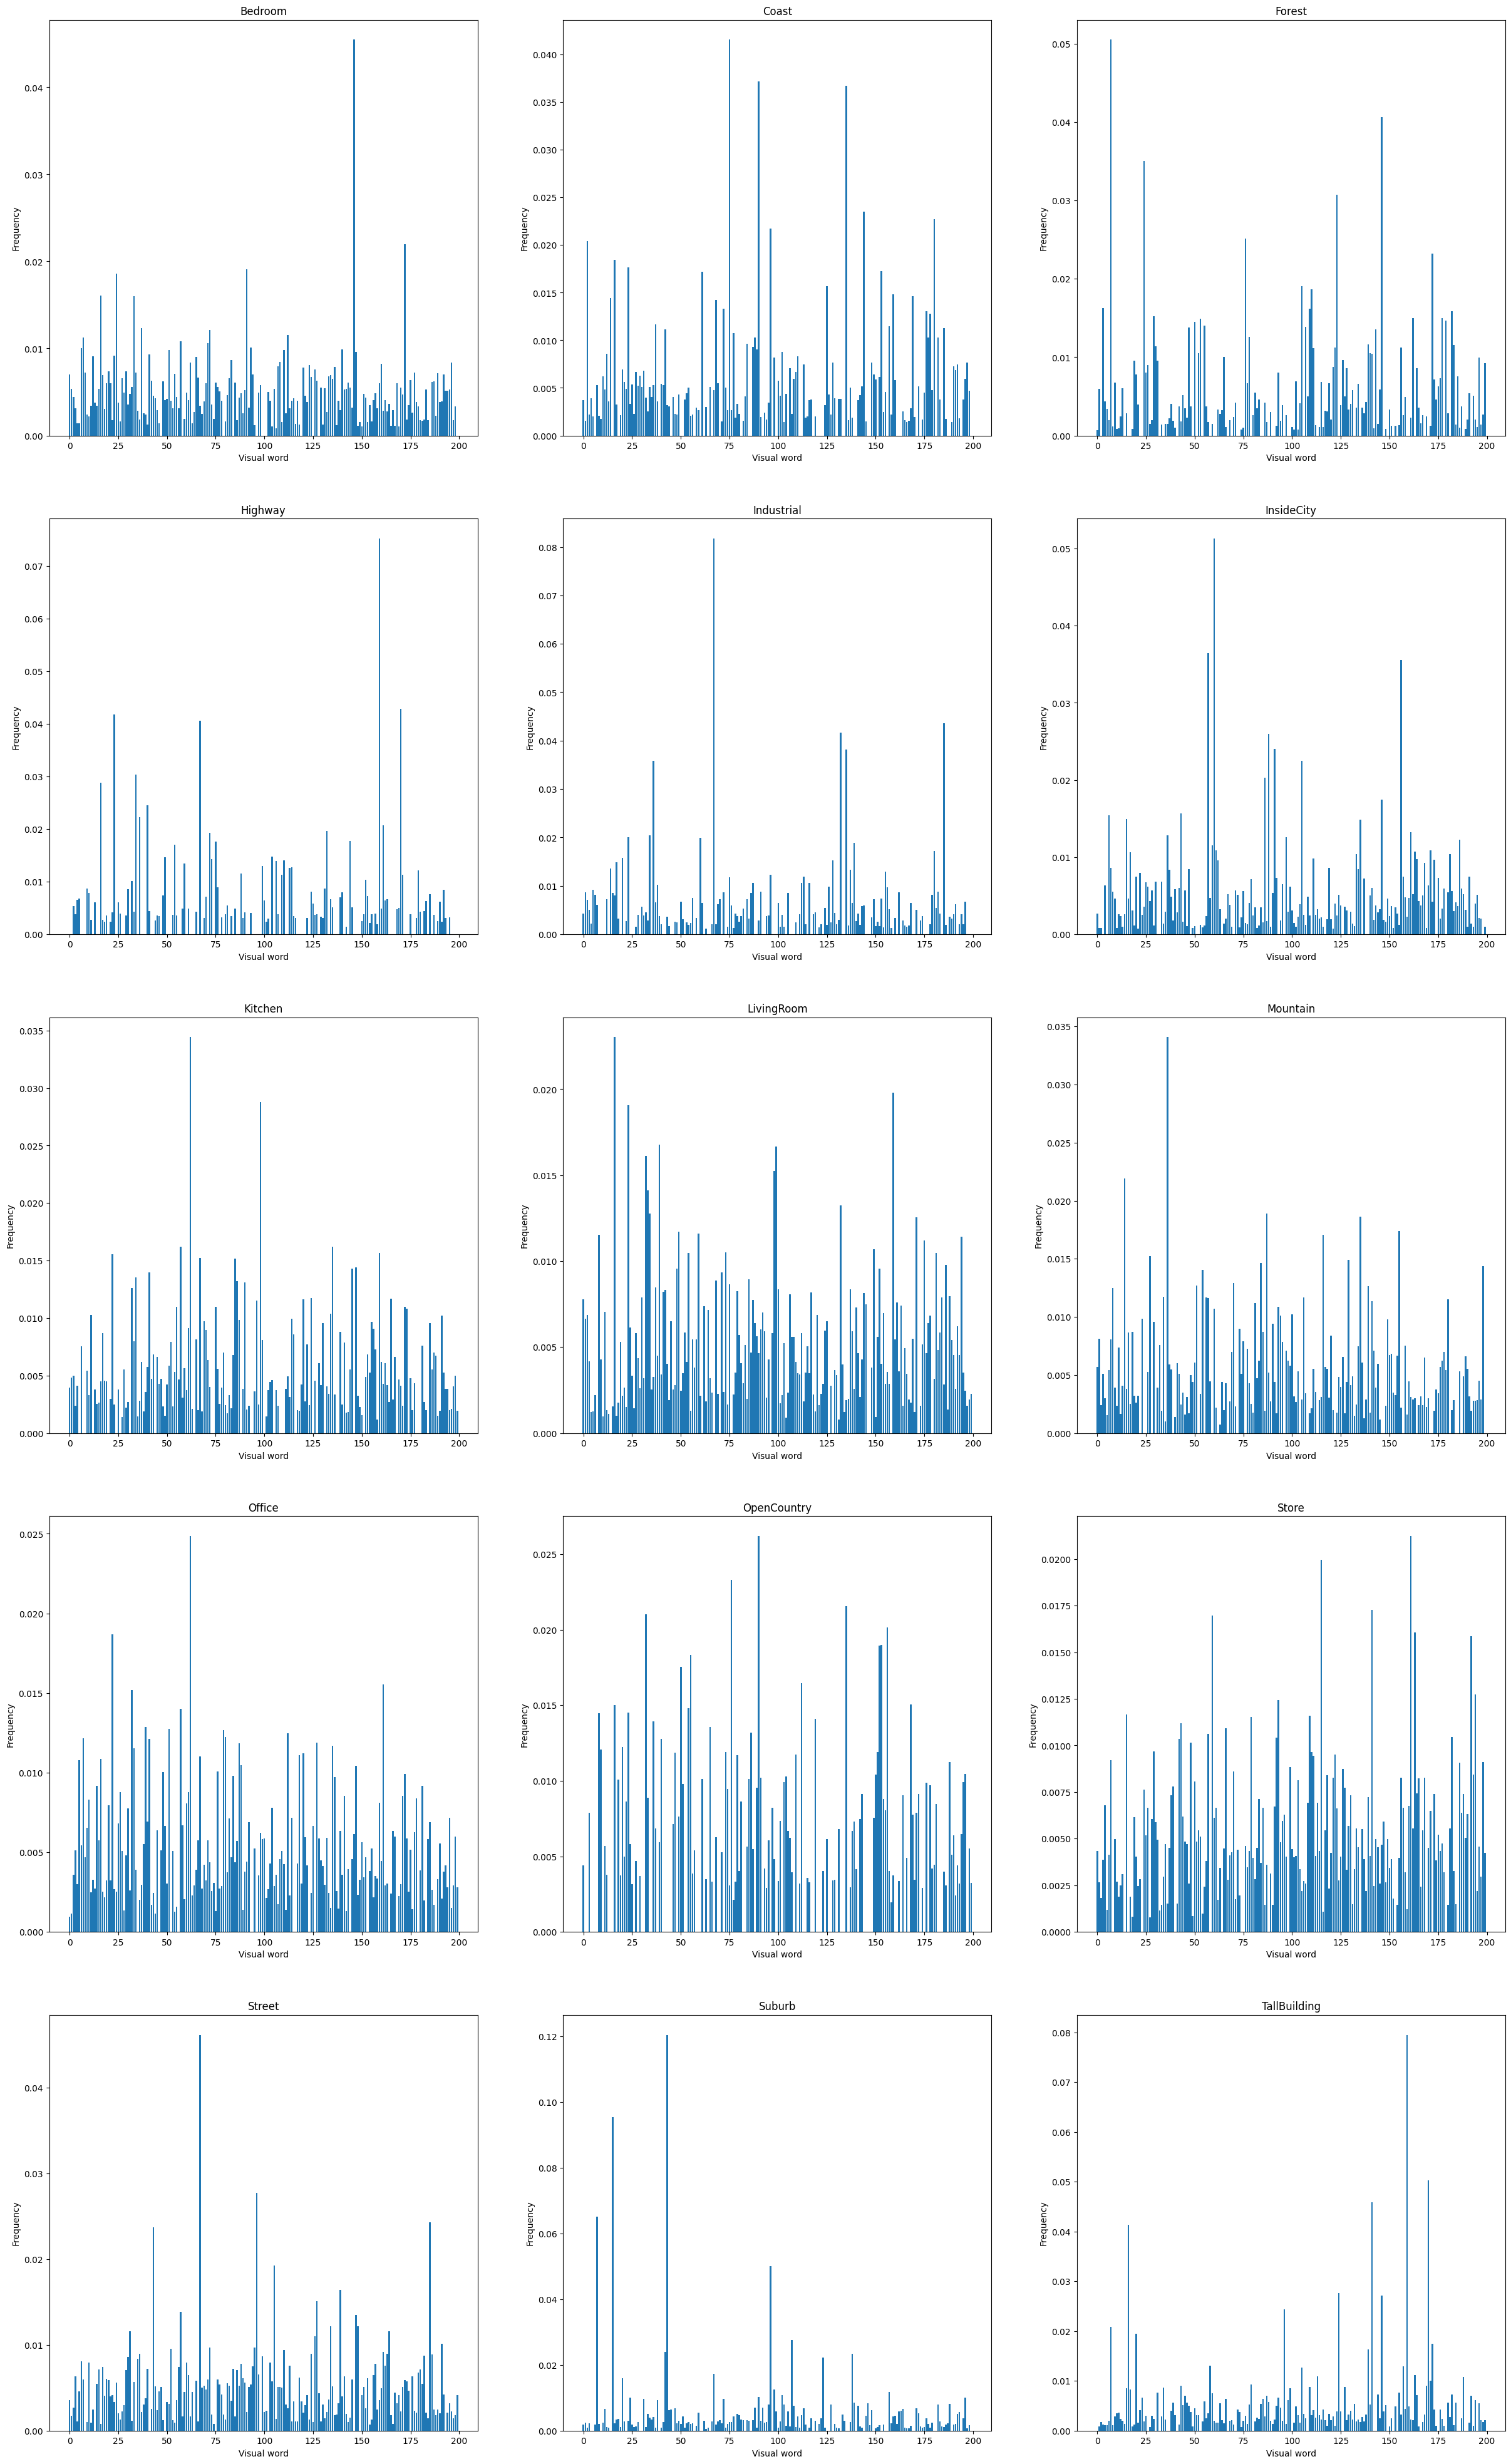

In [8]:
fig, ax = plt.subplots(5, 3, figsize=(30, 50))
i = [normalized_train_histograms[idx]['tf_idf'] for idx in indices]
l = [normalized_train_histograms[idx]['label'] for idx in indices]
ax = np.ravel(ax)
for index, hist in enumerate(i):
    ax[index].bar(list(range(CLUSTER_NUMBER)), hist)
    ax[index].set_xlabel('Visual word')
    ax[index].set_ylabel('Frequency')
    ax[index].set_title(l[index])
plt.show()

## Test and accessment phase

#### Compute test histograms and normalize them through TF-IDF

In [9]:
def get_test_histograms(images):
    test_sift_descriptors = extract_sift_descriptors(images, N_SIFT_FEATURES)
    quantized_test_images = vv.quantize_images(test_sift_descriptors)
    test_histograms = create_histograms(quantized_test_images, vv.vocabulary)
    UNC_test_images = vv.UNC_images(test_sift_descriptors)
    UNC_test_histograms = create_UNC_histogram(UNC_test_images, vocabulary)
    pyramid_test_histogram = vv.compute_pyramid_descriptor(images, 2)
    return test_histograms, UNC_test_histograms, pyramid_test_histogram

We decide to keep these line code to show you how we computed the different values that we will use soon.

WARNING: unfortunately, due to the heavy computation of the UNC, we implement a code which use the GPU to calculate these values. So to run the code below you must have a GPU with CUDA's drivers.

Use the values that we have already computed for you.

In [13]:
test_histograms, UNC_test_histogram, pyramid_test_histogram = get_test_histograms(test_images)
vv_file = open('pickled/quantized_test.pkl', 'wb')
pickle.dump(test_histograms, vv_file)
vv_file = open('pickled/UNC_test.pkl', 'wb')
pickle.dump(UNC_test_histogram, vv_file)
vv_file = open('pickled/pyramid_test.pkl', 'wb')
pickle.dump(pyramid_test_histogram , vv_file)

Run all the other cells from here

In [10]:
vv_file = open('pickled/quantized_test.pkl', 'rb')
test_histograms = pickle.load(vv_file)
vv_file = open('pickled/UNC_test.pkl', 'rb')
UNC_test_histogram = pickle.load(vv_file)
vv_file = open('pickled/pyramid_test.pkl', 'rb')
pyramid_test_histogram = pickle.load(vv_file)

Clearly we need to normalize with the IDF computed on the train set.

In [11]:
normalized_test_histograms = tfidf_histograms(test_histograms, idf_train)

Here, we create the effective train and test sets, suitable for input into the classification models.

In [12]:
X_train = [item['tf_idf'] for item in normalized_train_histograms]
y_train = [item['label'] for item in normalized_train_histograms]
X_test = [item['tf_idf'] for item in normalized_test_histograms]
y_test = [item['label'] for item in normalized_test_histograms]

### KNN model

In [13]:
def knn(X_train, y_train, X_test, y_test, n_neighbors=10, metric=chi_squared_distance):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("Test accuracy = ", accuracy_score(y_test, y_pred) * 100)
    show_confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:\n")
    print(report)

Results with the Cosine Similarity distance metric.

Test accuracy =  43.785594639866


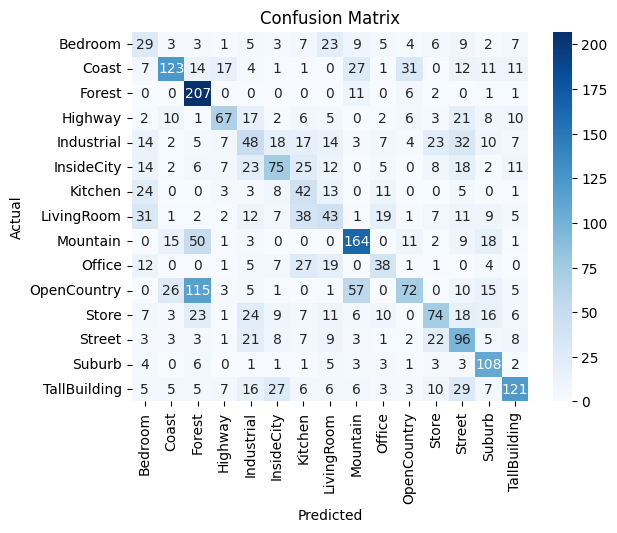

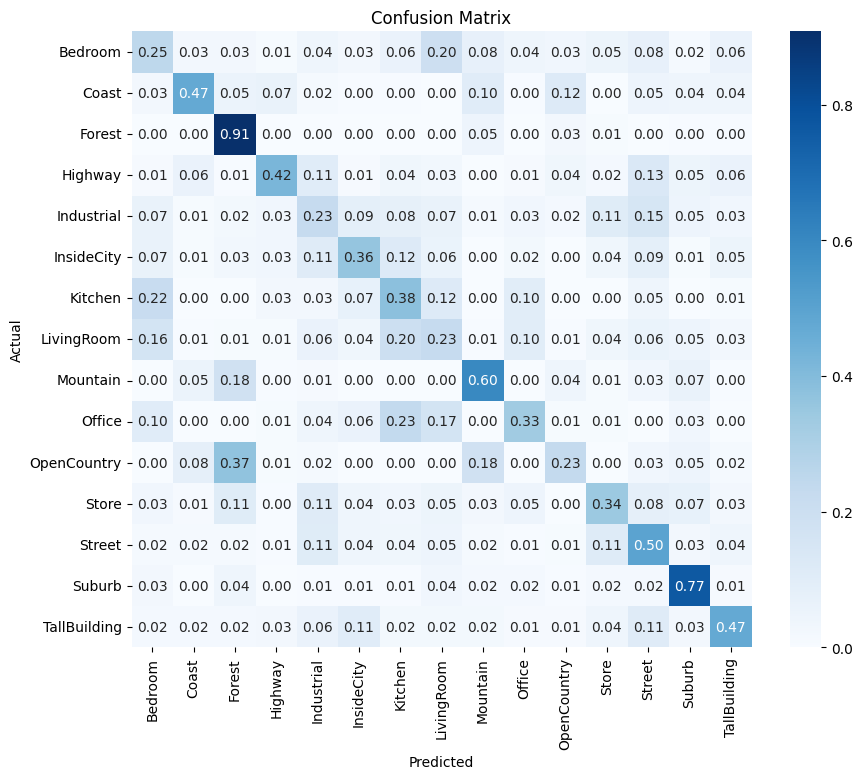


Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.19      0.25      0.22       116
       Coast       0.64      0.47      0.54       260
      Forest       0.47      0.91      0.62       228
     Highway       0.57      0.42      0.48       160
  Industrial       0.26      0.23      0.24       211
  InsideCity       0.45      0.36      0.40       208
     Kitchen       0.23      0.38      0.29       110
  LivingRoom       0.27      0.23      0.25       189
    Mountain       0.57      0.60      0.58       274
      Office       0.36      0.33      0.35       115
 OpenCountry       0.51      0.23      0.32       310
       Store       0.46      0.34      0.39       215
      Street       0.35      0.50      0.41       192
      Suburb       0.50      0.77      0.61       141
TallBuilding       0.62      0.47      0.54       256

    accuracy                           0.44      2985
   macro avg       0.43      0.43      0.42      2985
w

In [14]:
result = knn(X_train, y_train, X_test, y_test, metric='cosine')

Results with distance metric "Chi-squared"

Test accuracy =  44.7571189279732


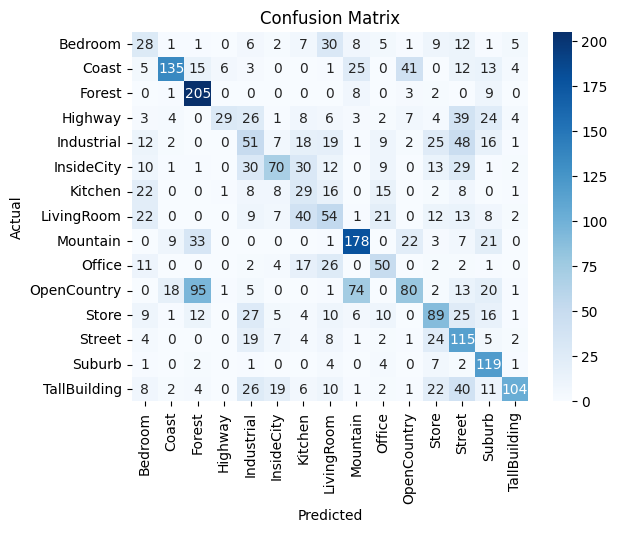

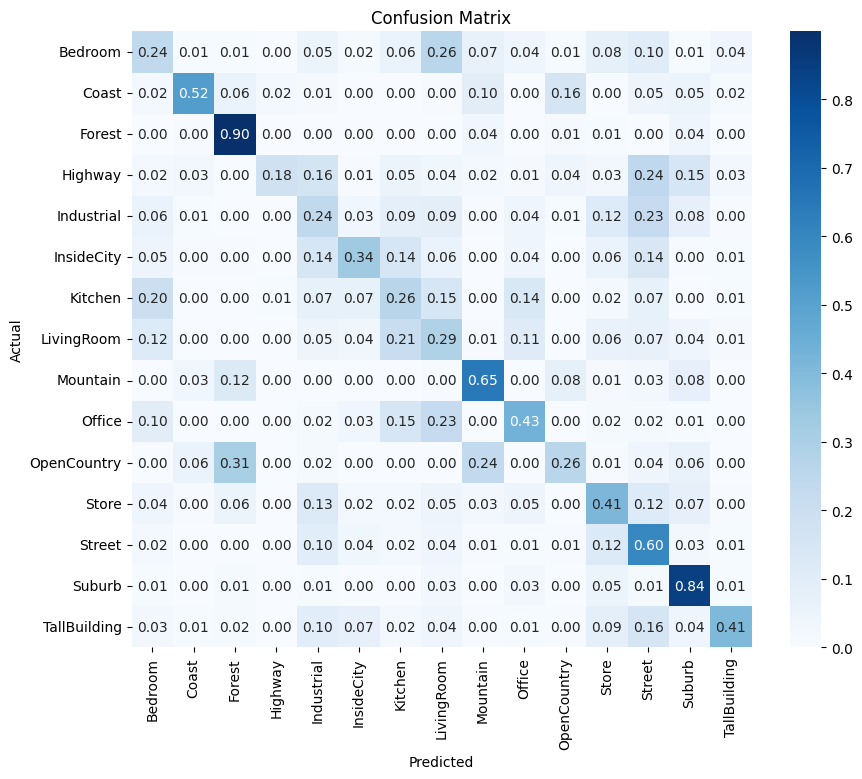


Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.21      0.24      0.22       116
       Coast       0.78      0.52      0.62       260
      Forest       0.56      0.90      0.69       228
     Highway       0.78      0.18      0.29       160
  Industrial       0.24      0.24      0.24       211
  InsideCity       0.54      0.34      0.41       208
     Kitchen       0.18      0.26      0.21       110
  LivingRoom       0.27      0.29      0.28       189
    Mountain       0.58      0.65      0.61       274
      Office       0.39      0.43      0.41       115
 OpenCountry       0.51      0.26      0.34       310
       Store       0.41      0.41      0.41       215
      Street       0.32      0.60      0.41       192
      Suburb       0.45      0.84      0.59       141
TallBuilding       0.81      0.41      0.54       256

    accuracy                           0.45      2985
   macro avg       0.47      0.44      0.42      2985
w

In [15]:
result = knn(X_train, y_train, X_test, y_test)

### SVM models

#### Linear multiclass SVM

Test accuracy =  47.33668341708543

Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.31      0.29      0.30       116
       Coast       0.51      0.66      0.57       260
      Forest       0.48      0.97      0.65       228
     Highway       0.48      0.62      0.54       160
  Industrial       0.28      0.18      0.22       211
  InsideCity       0.48      0.51      0.50       208
     Kitchen       0.33      0.30      0.31       110
  LivingRoom       0.38      0.21      0.27       189
    Mountain       0.67      0.54      0.60       274
      Office       0.42      0.61      0.50       115
 OpenCountry       0.46      0.13      0.21       310
       Store       0.47      0.35      0.40       215
      Street       0.48      0.35      0.41       192
      Suburb       0.53      0.79      0.63       141
TallBuilding       0.48      0.61      0.54       256

    accuracy                           0.47      2985
   macro avg       0

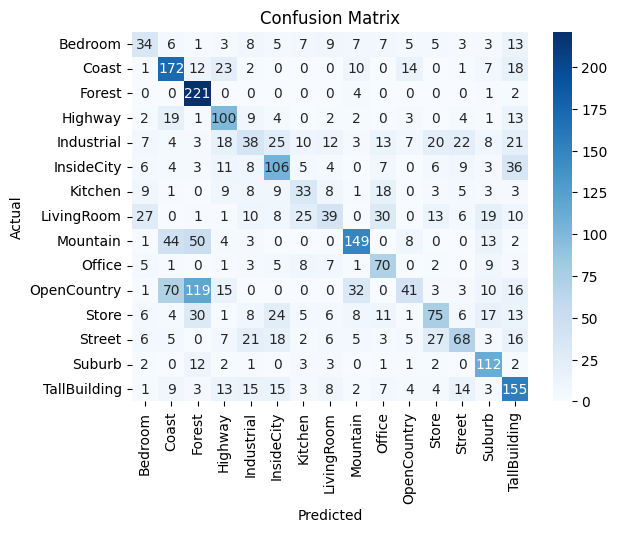

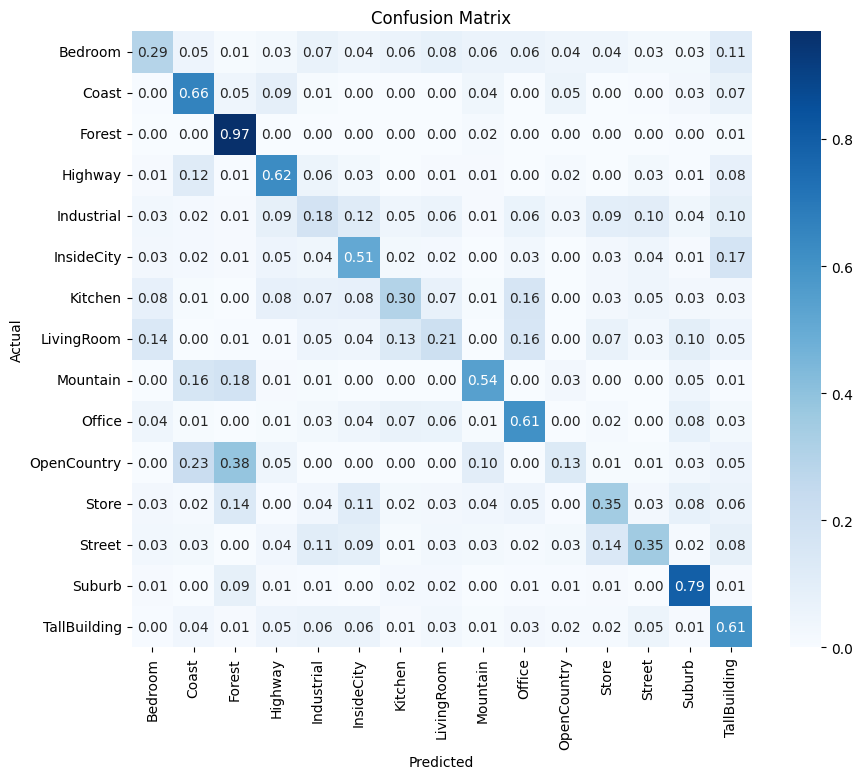

In [16]:
linear_svm = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
y_pred = linear_svm.predict(X_test)
print("Test accuracy = ", accuracy_score(y_test, y_pred) * 100)
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n")
print(report)
show_confusion_matrix(y_test, y_pred)

#### Gaussian multiclass SVM

Test accuracy =  54.773869346733676

Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.41      0.33      0.37       116
       Coast       0.62      0.65      0.64       260
      Forest       0.61      0.93      0.73       228
     Highway       0.57      0.69      0.62       160
  Industrial       0.43      0.24      0.31       211
  InsideCity       0.54      0.57      0.56       208
     Kitchen       0.42      0.37      0.40       110
  LivingRoom       0.48      0.22      0.30       189
    Mountain       0.65      0.70      0.68       274
      Office       0.49      0.71      0.58       115
 OpenCountry       0.54      0.35      0.42       310
       Store       0.52      0.45      0.48       215
      Street       0.50      0.55      0.52       192
      Suburb       0.47      0.90      0.62       141
TallBuilding       0.62      0.56      0.59       256

    accuracy                           0.55      2985
   macro avg       

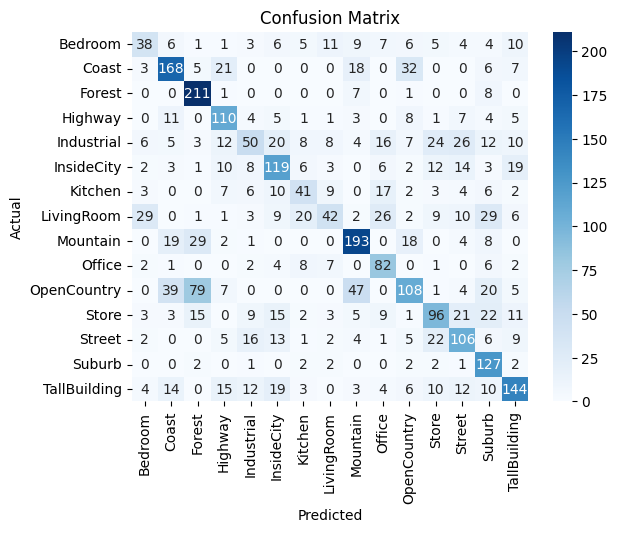

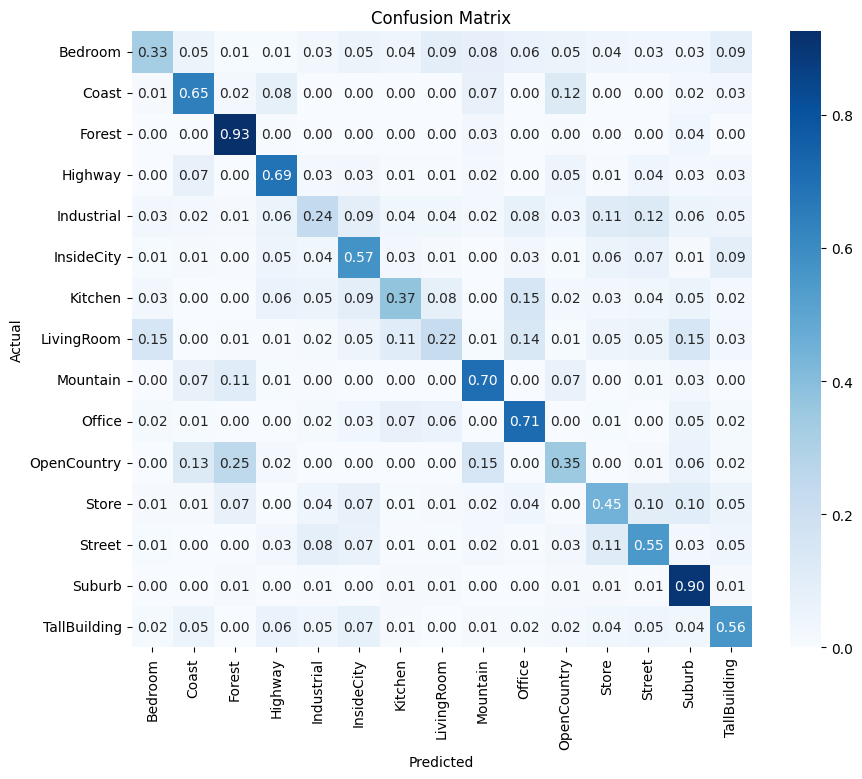

In [17]:
gaussian_svm = OneVsRestClassifier(SVC(kernel='rbf')).fit(X_train, y_train)
y_pred = gaussian_svm.predict(X_test)
print("Test accuracy = ", accuracy_score(y_test, y_pred) * 100)
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n")
print(report)
show_confusion_matrix(y_test, y_pred)

#### SVM with generalized Gaussian kernel based on the χ2 distance

Test accuracy =  58.391959798994975

Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.48      0.39      0.43       116
       Coast       0.66      0.70      0.68       260
      Forest       0.67      0.93      0.78       228
     Highway       0.66      0.74      0.70       160
  Industrial       0.48      0.20      0.29       211
  InsideCity       0.57      0.59      0.58       208
     Kitchen       0.39      0.33      0.36       110
  LivingRoom       0.40      0.21      0.28       189
    Mountain       0.67      0.69      0.68       274
      Office       0.48      0.77      0.59       115
 OpenCountry       0.64      0.49      0.56       310
       Store       0.54      0.48      0.51       215
      Street       0.46      0.62      0.53       192
      Suburb       0.52      0.91      0.66       141
TallBuilding       0.73      0.63      0.68       256

    accuracy                           0.58      2985
   macro avg       

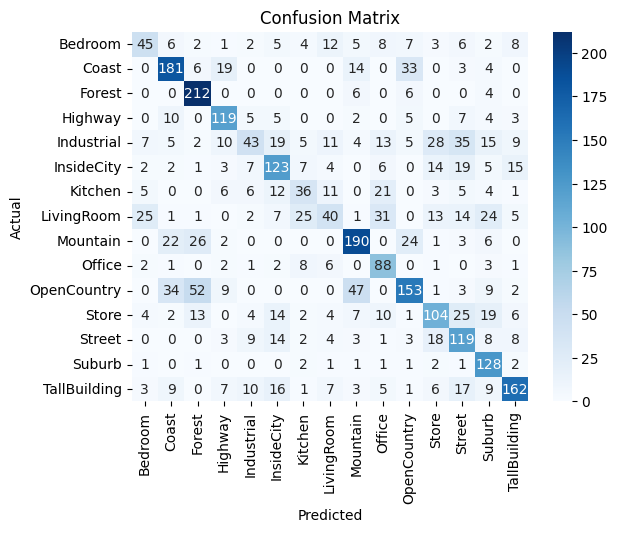

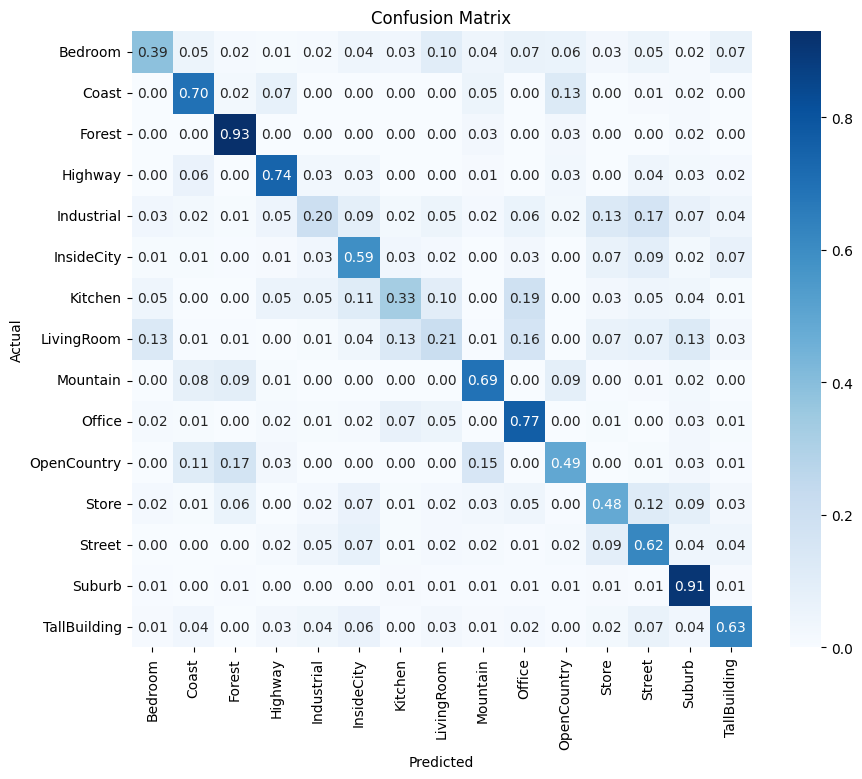

In [18]:
GAMMA = 3
K_train = chi2_kernel(X_train, X_train, gamma=GAMMA)
K_test = chi2_kernel(X_test, X_train, gamma=GAMMA)

chi_svm = OneVsRestClassifier(SVC(kernel='precomputed'))
clf_chi_svm= chi_svm.fit(K_train, y_train)
y_pred = clf_chi_svm.predict(K_test)

print("Test accuracy = ", accuracy_score(y_test, y_pred) * 100)
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n")
print(report)
show_confusion_matrix(y_test, y_pred)

#### Multiclass SVM using the Error Correcting Output Code approach

Test accuracy =  59.09547738693467

Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.45      0.46      0.45       116
       Coast       0.69      0.69      0.69       260
      Forest       0.72      0.91      0.80       228
     Highway       0.67      0.70      0.69       160
  Industrial       0.46      0.18      0.26       211
  InsideCity       0.59      0.59      0.59       208
     Kitchen       0.39      0.38      0.39       110
  LivingRoom       0.41      0.31      0.35       189
    Mountain       0.68      0.69      0.68       274
      Office       0.50      0.71      0.59       115
 OpenCountry       0.63      0.52      0.57       310
       Store       0.51      0.59      0.55       215
      Street       0.48      0.56      0.52       192
      Suburb       0.55      0.90      0.68       141
TallBuilding       0.75      0.62      0.68       256

    accuracy                           0.59      2985
   macro avg       0

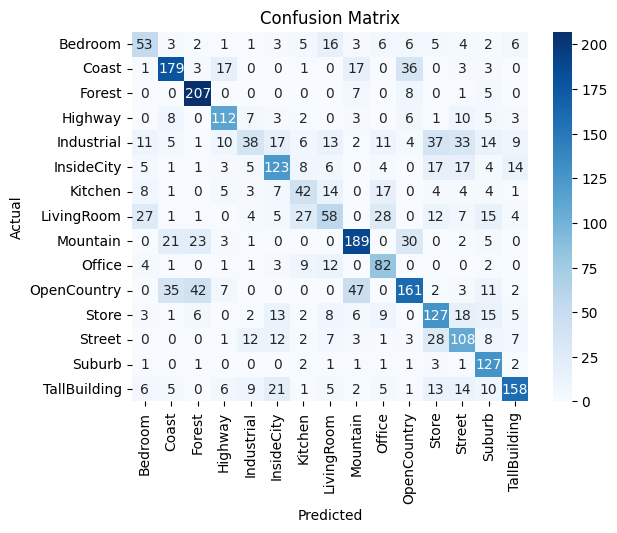

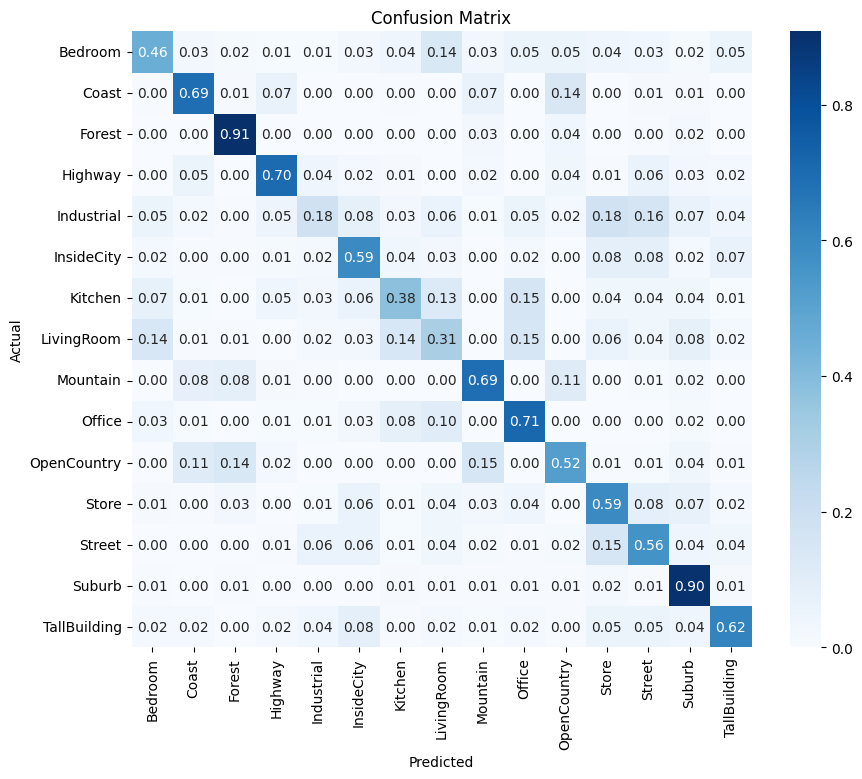

In [19]:
ecoc_chi = OutputCodeClassifier(estimator=chi_svm, code_size=45, random_state=42).fit(K_train, y_train)

y_pred_ecoc_chi = ecoc_chi.predict(K_test)
print("Test accuracy = ", accuracy_score(y_test, y_pred_ecoc_chi) * 100)
report = classification_report(y_test, y_pred_ecoc_chi)
print("\nClassification Report:\n")
print(report)

show_confusion_matrix(y_test, y_pred_ecoc_chi)

#### Multiclass SVM using the Codeword Uncertainty formula to perform a Soft Assignment

In [20]:
X_train_UNC = [item['histogram'] for item in UNC_train_histogram]
y_train_UNC = [item['label'] for item in UNC_train_histogram]
X_test_UNC = [item['histogram'] for item in UNC_test_histogram]
y_test_UNC = [item['label'] for item in UNC_test_histogram]

Test accuracy =  54.33835845896148

Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.29      0.20      0.24       116
       Coast       0.62      0.65      0.63       260
      Forest       0.66      0.93      0.77       228
     Highway       0.49      0.73      0.58       160
  Industrial       0.40      0.16      0.23       211
  InsideCity       0.53      0.62      0.57       208
     Kitchen       0.33      0.25      0.29       110
  LivingRoom       0.40      0.26      0.32       189
    Mountain       0.60      0.57      0.59       274
      Office       0.49      0.71      0.58       115
 OpenCountry       0.58      0.45      0.51       310
       Store       0.63      0.52      0.57       215
      Street       0.52      0.56      0.54       192
      Suburb       0.45      0.91      0.61       141
TallBuilding       0.67      0.54      0.60       256

    accuracy                           0.54      2985
   macro avg       0

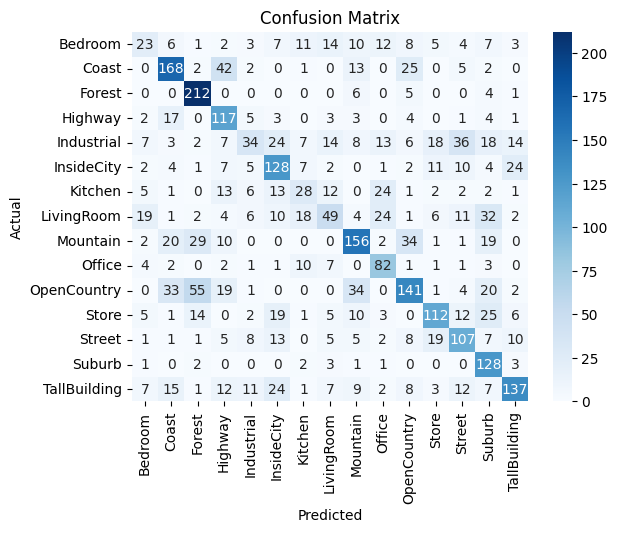

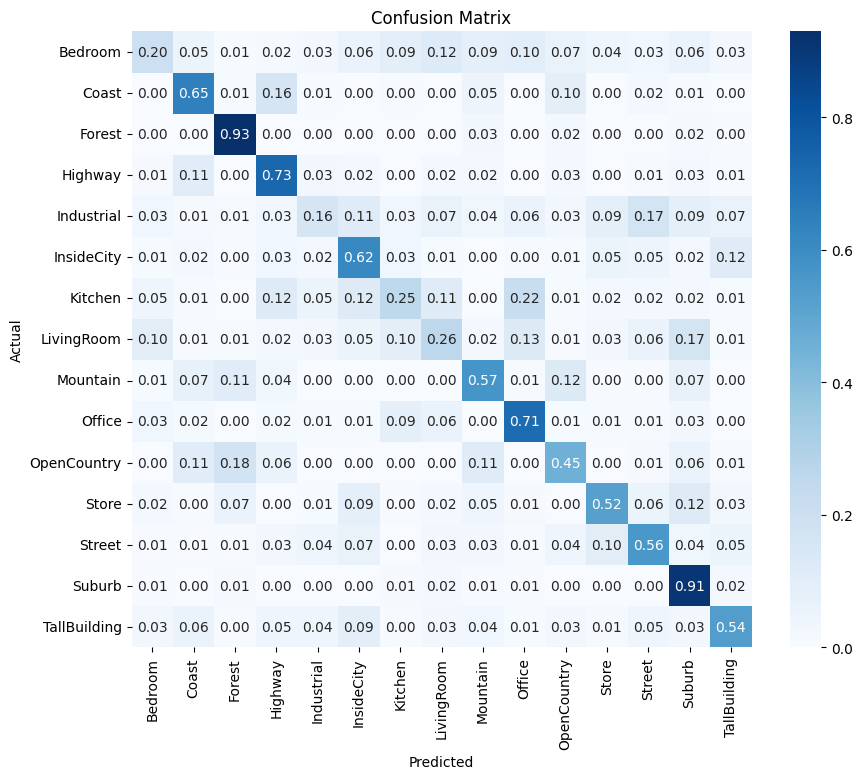

In [21]:
GAMMA = 3
K_train_UNC = chi2_kernel(X_train_UNC, X_train_UNC, gamma=GAMMA)
K_test_UNC = chi2_kernel(X_test_UNC, X_train_UNC, gamma=GAMMA)

UNC_svm = OneVsRestClassifier(SVC(kernel='precomputed')).fit(K_train_UNC, y_train_UNC)

y_pred_UNC = UNC_svm.predict(K_test_UNC)
print("Test accuracy = ", accuracy_score(y_test_UNC, y_pred_UNC) * 100)

report = classification_report(y_test_UNC, y_pred_UNC)
print("\nClassification Report:\n")
print(report)

show_confusion_matrix(y_test_UNC, y_pred_UNC)

#### Multiclass SVM using the the Spatial Pyramid Kernel

In [22]:
X_train_pyramid = [item['histogram'] for item in pyramid_train_histogram]
y_train_pyramid = [item['label'] for item in pyramid_train_histogram]
X_test_pyramid = [item['histogram'] for item in pyramid_test_histogram]
y_test_pyramid = [item['label'] for item in pyramid_test_histogram]

Test accuracy =  58.92797319932998

Classification Report:

              precision    recall  f1-score   support

     Bedroom       0.33      0.39      0.36       116
       Coast       0.68      0.63      0.66       260
      Forest       0.86      0.89      0.88       228
     Highway       0.64      0.79      0.71       160
  Industrial       0.37      0.28      0.32       211
  InsideCity       0.53      0.45      0.49       208
     Kitchen       0.29      0.34      0.31       110
  LivingRoom       0.32      0.26      0.29       189
    Mountain       0.63      0.55      0.59       274
      Office       0.46      0.66      0.54       115
 OpenCountry       0.55      0.59      0.57       310
       Store       0.63      0.66      0.64       215
      Street       0.67      0.71      0.69       192
      Suburb       0.72      0.87      0.78       141
TallBuilding       0.77      0.66      0.71       256

    accuracy                           0.59      2985
   macro avg       0

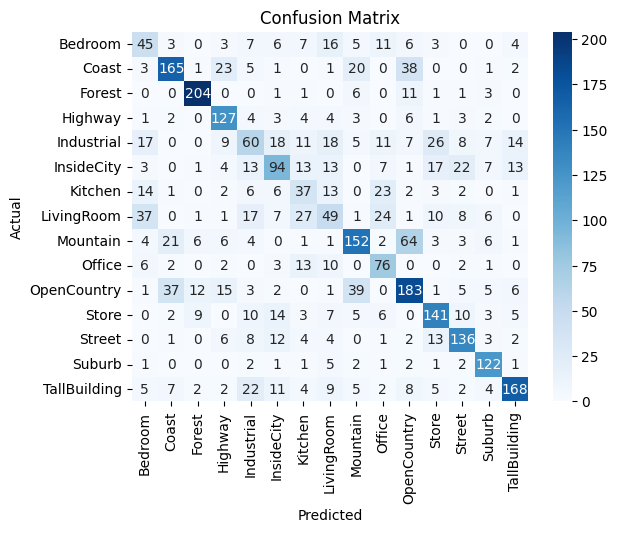

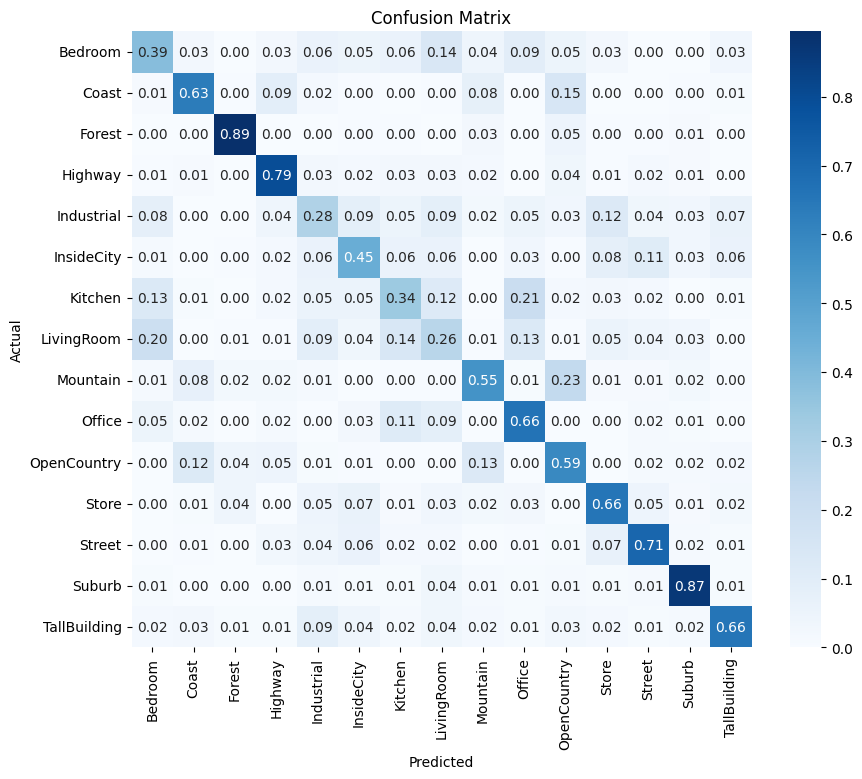

In [23]:
levels = 2 
K_train, K_test = compute_kernel_matrix(X_train_pyramid, X_test_pyramid, levels)

pyramid_svm = OneVsRestClassifier(SVC(kernel='precomputed')).fit(K_train, y_train_pyramid)
y_pred_pyramid = pyramid_svm.predict(K_test)

print("Test accuracy = ", accuracy_score(y_test_pyramid, y_pred_pyramid) * 100)

report = classification_report(y_test_pyramid, y_pred_pyramid)
print("\nClassification Report:\n")
print(report)

show_confusion_matrix(y_test_pyramid, y_pred_pyramid)